In [2]:
!pip install geopandas osmnx networkx matplotlib contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 7.8 MB/s eta 0:00:00


In [3]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point

In [4]:
latitude = 49.2966
longitude = -123.1417

G= ox.graph_from_point((latitude, longitude), dist=2000, network_type='walk')

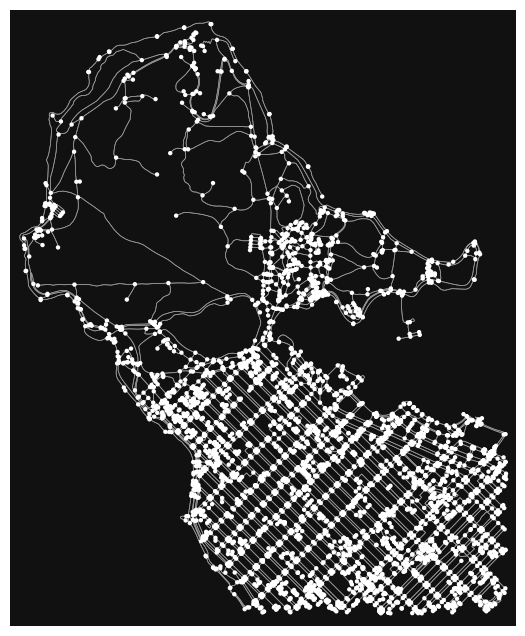

In [5]:
fig, ax = ox.plot_graph(G, node_size=10, edge_linewidth=0.5)

<Axes: >

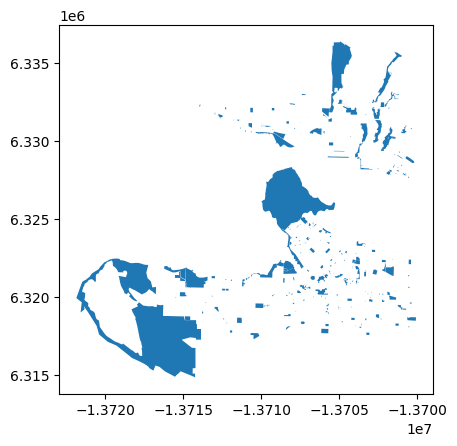

In [6]:
tags = {'leisure': ['park', 'garden', 'recreation_ground', 'natural_reserve']}

green_spaces = ox.features_from_point((latitude,longitude), tags=tags, dist=5000)

green_spaces = green_spaces[green_spaces.geometry.type.isin(['Polygon', 'MultiPolygon'])]
green_spaces = green_spaces.to_crs(crs='EPSG:3857')
green_spaces.plot()

<Axes: >

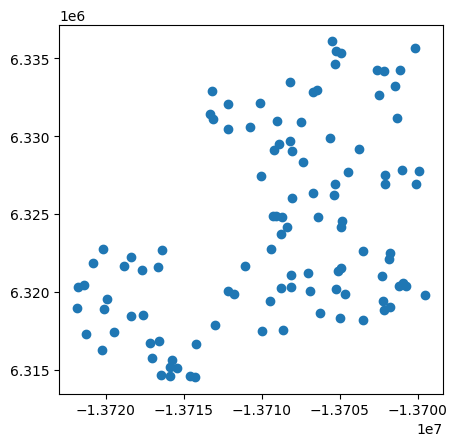

In [7]:
import random
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

area_polygon = unary_union(green_spaces.buffer(1000).geometry)

res_points = []
while len(res_points) < 108:
  x= random.uniform(area_polygon.bounds[0], area_polygon.bounds[2])
  y = random.uniform(area_polygon.bounds[1], area_polygon.bounds[3])
  point = Point(x, y)
  if area_polygon.contains(point):
    res_points.append(point)

res_gdf = gpd.GeoDataFrame(geometry = res_points, crs="EPSG:3857")
res_gdf.plot()

In [8]:
res_gdf = res_gdf.to_crs(epsg=4326)

# Reproject green_spaces to a projected CRS (e.g., EPSG:3857) for accurate centroid calculation
green_spaces_projected = green_spaces.to_crs(epsg=3857)
park_centroids_projected = green_spaces_projected.geometry.centroid
# Reproject centroids back to EPSG:4326 for use with ox.distance.nearest_nodes
park_centroids = park_centroids_projected.to_crs(epsg=4326)

res_nodes = [ox.distance.nearest_nodes(G, point.x, point.y) for point in res_gdf.geometry]
park_nodes = [ox.distance.nearest_nodes(G, pt.x, pt.y) for pt in park_centroids]

In [9]:
import networkx as nx
import numpy as np

distances = []
for res_node in res_nodes:
  # Calculate shortest path lengths from res_node to all reachable nodes
  # This returns a dictionary {target_node: path_length}
  all_lengths_from_res_node = nx.shortest_path_length(G, source=res_node, weight='length')

  # Find the minimum distance from res_node to any park_node
  min_dist_to_park = float('inf')
  for park_node in park_nodes:
    if park_node in all_lengths_from_res_node:
      min_dist_to_park = min(min_dist_to_park, all_lengths_from_res_node[park_node])

  if min_dist_to_park == float('inf'):
    # If no park is reachable from the res_node, assign NaN
    distances.append(np.nan)
  else:
    distances.append(min_dist_to_park)

# Add to GeoDataFrame
res_gdf['green_space_distance_m'] = distances
res_gdf['green_space_distance_km'] = res_gdf['green_space_distance_m'] / 1000

In [10]:
m = folium.Map(location = [latitude, longitude], zoom_start =13)

for _, row in green_spaces.iterrows():
  folium.GeoJson(row.geometry, style_function = lambda x: {'fillColor': 'green'}) .add_to(m)

for _, row in res_gdf.iterrows():
  folium.CircleMarker(
      location=[row['geometry'].y, row['geometry'].x],
      radius=5,
      popup=f"Distance: {row['green_space_distance_km']:.2f} km",
      color='blue',
      fill=True,
      fill_opacity=0.7
  ).add_to(m)

m

In [11]:
res_gdf.to_file("residential_green_access.geojson", driver="GeoJSON")

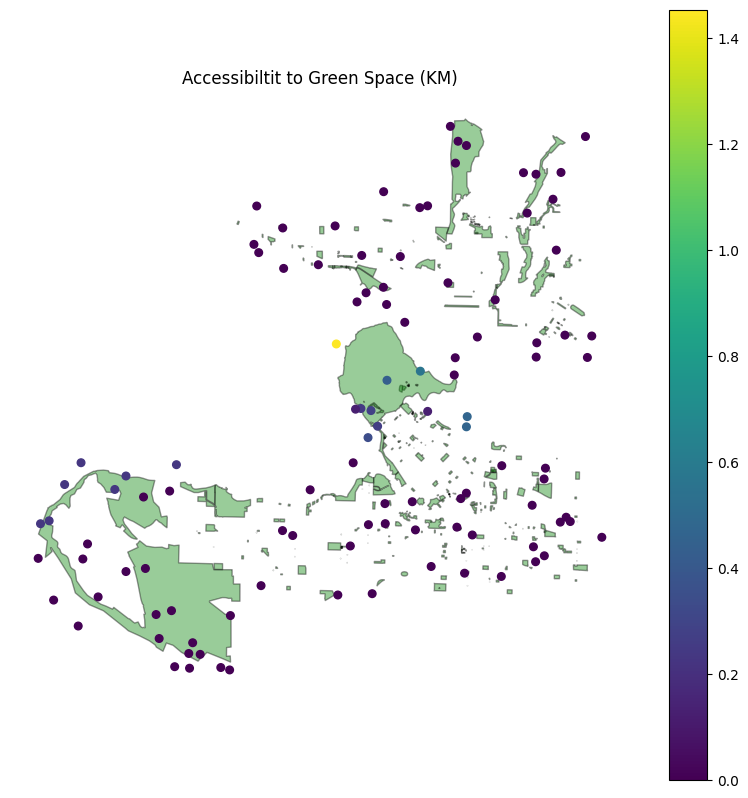

In [13]:
import matplotlib.pyplot as plt
res_gdf_plot = res_gdf.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize = (10,10))
green_spaces.plot(ax=ax, color='green', alpha=0.4, edgecolor='black')
res_gdf_plot.plot(ax=ax, column = 'green_space_distance_km', cmap='viridis', legend=True, markersize=30)

plt.title("Accessibiltit to Green Space (KM)")
plt.axis('off')
plt.show()

In [17]:
import folium
import branca.colormap # Import branca.colormap module directly

color_scale = branca.colormap.linear.viridis.scale(
  res_gdf["green_space_distance_km"].min(),
  res_gdf['green_space_distance_km'].max())

m = folium.Map(location=[latitude, longitude], zoom_start=13)
for _, row in green_spaces.iterrows():
  folium.GeoJson(
    row.geometry, style_function=lambda X: {'color': 'green', 'fillOpacity': 0.3} # Corrected typo '11110pacity'
  ).add_to(m)
# Add residential points with color-coded distances
for _,row in res_gdf.iterrows():
  folium.CircleMarker(
    location=[row.geometry.y, row.geometry.x],
    radius=6,
    color=color_scale(row['green_space_distance_km']),
    fill=True,
    fill_opacity=0.9,
    popup=f"Distance: {row['green_space_distance_km']:.2f} km",
  ).add_to(m)
color_scale.caption = 'Distance to Nearest Green Space (km)' # Corrected typo '. caption'
color_scale.add_to(m)

m

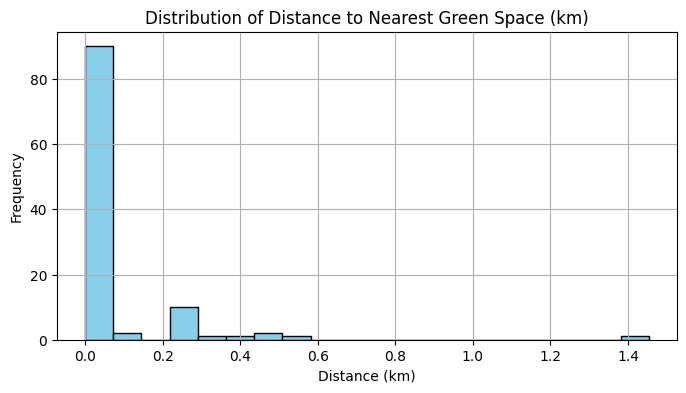

In [18]:
res_gdf['green_space_distance_km'].plot.hist(bins=20, color='skyblue', edgecolor='black', figsize = (8,4))
plt.title("Distribution of Distance to Nearest Green Space (km)")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

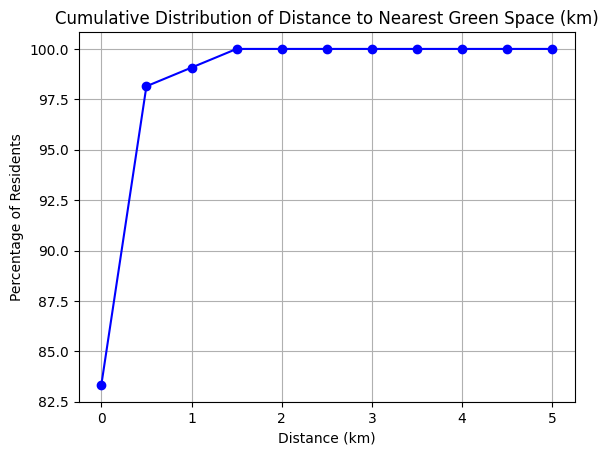

In [22]:
import numpy as np

thresholds = np.arange(0, 5.5, 0.5)
cumulative = [(res_gdf['green_space_distance_km'] <= t). mean() *100 for t in thresholds]

plt.plot(thresholds, cumulative, marker='o', linestyle='-', color='b')
plt.title("Cumulative Distribution of Distance to Nearest Green Space (km)")
plt.xlabel("Distance (km)")
plt.ylabel("Percentage of Residents")
plt.grid(True)
plt.show()

In [24]:
print ("Accessibility Summary")
print(f"Min Distance: {res_gdf['green_space_distance_km'].min():.2f} km")
print(f"Max Distance: {res_gdf['green_space_distance_km'].max():.2f} km")
print(f"Mean Distance: {res_gdf['green_space_distance_km'].mean():.2f} km")
print(f"Median Distance: {res_gdf['green_space_distance_km'].median():.2f} km")

Accessibility Summary
Min Distance: 0.00 km
Max Distance: 1.45 km
Mean Distance: 0.06 km
Median Distance: 0.00 km


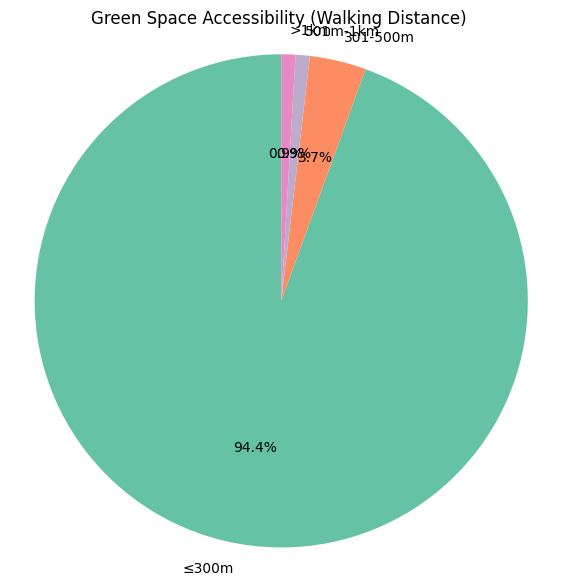

In [26]:
import matplotlib.pyplot as plt

labels = ['≤300m', '301-500m', '501m-1km', '>1km']

distances_km = res_gdf['green_space_distance_km']

# Calculate percentages for the pie chart categories
p_le_300m = (distances_km <= 0.3).mean() * 100
p_le_500m = (distances_km <= 0.5).mean() * 100
p_le_1km = (distances_km <= 1.0).mean() * 100

size_le_300m = p_le_300m
size_301_500m = p_le_500m - p_le_300m
size_501_1km = p_le_1km - p_le_500m
size_gt_1km = 100 - p_le_1km # Remaining percentage

sizes = [size_le_300m, size_301_500m, size_501_1km, size_gt_1km]

colors = ['#66c2a5', '#fc8d62',
'#BdaBcb',
'#e78ac3']
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%'
, startangle=90)
plt.title('Green Space Accessibility (Walking Distance) ')
plt.axis('equal')
plt.show()

In [27]:
print("\n--- Green Space Accessibility Summary ---")
print(f"On average, residents in this area are {res_gdf['green_space_distance_km'].mean():.2f} km away from the nearest green space.")
print(f"{p_le_300m:.1f}% of residents live within 300 meters - which is considered excellent accessibility.")
print(f"{p_le_500m:.1f}% are within 500 meters, and {p_le_1km:.1f}% within 1 km.")
print(f"However, {size_gt_1km:.1f}% of residents are over 1 km away from any green space.")
print("This data can help city planners identify green space gaps and prioritize development.")


--- Green Space Accessibility Summary ---
On average, residents in this area are 0.06 km away from the nearest green space.
94.4% of residents live within 300 meters - which is considered excellent accessibility.
98.1% are within 500 meters, and 99.1% within 1 km.
However, 0.9% of residents are over 1 km away from any green space.
This data can help city planners identify green space gaps and prioritize development.
